<a href="https://colab.research.google.com/github/pe-gif/pe-gif.github.io/blob/main/Data_Project_Oregon_Trail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import random
import pandas as pd
from datetime import datetime, timedelta

# Professions and starting money
professions = {
    "Banker": 1600,
    "Carpenter": 800,
    "Farmer": 400
}

# Prices (per unit)
prices = {
    "food": 0.20,       # per pound
    "oxen": 40,         # each
    "ammo": 2,          # per 10 bullets
    "wheel": 10,        # wagon wheel
    "axle": 12,         # wagon axle
    "tongue": 15,       # wagon tongue
    "clothing": 10      # per set
}

# Travel styles
paces = ["steady", "strenuous", "grueling"]
rations = ["filling", "meager", "bare bones"]

# Valid departure months
start_months = {
    "March": datetime(1848, 3, 1),
    "April": datetime(1848, 4, 1),
    "May": datetime(1848, 5, 1),
    "June": datetime(1848, 6, 1),
    "July": datetime(1848, 7, 1)
}

# Key locations (mile markers)
locations = {
    100: "Kansas River Crossing",
    300: "Big Blue River Crossing",
    500: "Fort Kearney",
    780: "Chimney Rock",
    1020: "Fort Laramie",
    1250: "Independence Rock",
    1380: "South Pass",
    1560: "Fort Bridger",
    1700: "Green River",
    1900: "Fort Hall",
    2000: "Oregon City"
}

def buy_random_supplies(money):
    """Randomized purchase of supplies within budget."""
    while True:
        food = random.randint(500, 1500)   # lbs
        oxen = random.randint(2, 6)
        ammo = random.randint(100, 300)

        wheels = random.randint(1, 3)
        axles = random.randint(1, 3)
        tongues = random.randint(1, 2)

        clothing = random.randint(2, 10)

        cost = (
            food * prices["food"] +
            oxen * prices["oxen"] +
            (ammo / 10) * prices["ammo"] +
            wheels * prices["wheel"] +
            axles * prices["axle"] +
            tongues * prices["tongue"] +
            clothing * prices["clothing"]
        )

        if cost <= money:
            return food, oxen, ammo, wheels, axles, tongues, clothing, cost

def simulate_run(run_id):
    # Profession + money
    profession = random.choice(list(professions.keys()))
    money = professions[profession]

    # Starting supplies under budget
    food, oxen, ammo, wheels, axles, tongues, clothing, spent = buy_random_supplies(money)
    leftover_money = money - spent

    # Start month + date
    start_month = random.choice(list(start_months.keys()))
    current_date = start_months[start_month]

    # Stats
    miles = 0
    days = 0
    deaths = 0

    # Counters
    illnesses = 0
    hunts = 0
    rivers = 0
    clothing_lost = 0

    pace = random.choice(paces)
    ration = random.choice(rations)

    day_logs = []

    while miles < 2000 and oxen > 0 and food > 0 and deaths < 5:
        days += 1
        daily_events = []
        date_str = current_date.strftime("%Y-%m-%d")

        # distance traveled per day
        if pace == "steady":
            miles_today = 15
        elif pace == "strenuous":
            miles_today = 20
        else:
            miles_today = 25
        miles += miles_today

        # food consumption
        if ration == "filling":
            food_used = 20
        elif ration == "meager":
            food_used = 15
        else:
            food_used = 10
        food -= food_used

        # illness (higher in cold months with low clothing)
        cold_months = [11, 12, 1, 2]
        illness_chance = 0.05
        if current_date.month in cold_months and clothing < 3:
            illness_chance += 0.05
        if random.random() < illness_chance:
            illnesses += 1
            daily_events.append("illness")
            if random.random() < 0.2:
                deaths += 1
                daily_events.append("death")

        # wagon break (specific part)
        if random.random() < 0.03:
            part_broken = random.choice(["wheel", "axle", "tongue"])
            daily_events.append(f"{part_broken}_break")

            if part_broken == "wheel" and wheels > 0:
                wheels -= 1
            elif part_broken == "axle" and axles > 0:
                axles -= 1
            elif part_broken == "tongue" and tongues > 0:
                tongues -= 1
            else:
                miles -= 10  # no spare → lose progress

        # river crossing
        if random.random() < 0.02:
            rivers += 1
            daily_events.append("river_crossing")
            if random.random() < 0.2:
                food -= 50
                oxen -= 1
                clothing_lost += 1
                clothing = max(0, clothing - 1)
                daily_events.append("river_fail")

        # hunting (adaptive to food supply)
        if food < 200:
            hunt_chance = 0.6
        elif food < 500:
            hunt_chance = 0.4
        elif food < 1000:
            hunt_chance = 0.2
        else:
            hunt_chance = 0.05

        if random.random() < hunt_chance and ammo >= 5:
            hunts += 1
            hunt_gain = random.randint(50, 200)
            food += hunt_gain
            ammo -= 5
            daily_events.append(f"hunt_{hunt_gain}lbs")

        # clothing loss (more likely in winter)
        if random.random() < (0.01 if current_date.month not in cold_months else 0.03):
            if clothing > 0:
                clothing_lost += 1
                clothing -= 1
                daily_events.append("lost_clothing")

        # check for location
        if miles in locations:
            loc_name = locations[miles]
            daily_events.append(f"arrived_{loc_name}")
            if random.random() < 0.3:
                daily_events.append("talking")

        # log daily
        day_logs.append({
            "run_id": run_id,
            "day": days,
            "date": date_str,
            "miles_total": miles,
            "food_left": max(food, 0),
            "oxen_left": oxen,
            "ammo_left": ammo,
            "wheels_left": wheels,
            "axles_left": axles,
            "tongues_left": tongues,
            "clothing_left": clothing,
            "deaths_total": deaths,
            "events": ", ".join(daily_events) if daily_events else "none",
            "pace": pace,
            "ration": ration
        })

        # advance time
        current_date += timedelta(days=1)

        if food <= 0:
            break

    outcome = "success" if miles >= 2000 and deaths < 5 else "failure"

    run_summary = {
        "run_id": run_id,
        "profession": profession,
        "pace": pace,
        "ration": ration,
        "start_month": start_month,
        "outcome": outcome,
        "days": days,
        "miles": miles,
        "illnesses": illnesses,
        "deaths": deaths,
        "hunts": hunts,
        "rivers": rivers,
        "clothing_lost": clothing_lost,
        "food_left": max(food, 0),
        "oxen_left": oxen,
        "ammo_left": ammo,
        "wheels_left": wheels,
        "axles_left": axles,
        "tongues_left": tongues,
        "clothing_left": clothing,
        "money_spent": round(spent, 2),
        "money_left": round(leftover_money, 2)
    }

    return run_summary, day_logs


# Run multiple simulations
run_summaries = []
all_day_logs = []

for i in range(1, 51):  # 50 runs, can scale up
    run_summary, day_logs = simulate_run(i)
    run_summaries.append(run_summary)
    all_day_logs.extend(day_logs)

# Convert to DataFrames
df_runs = pd.DataFrame(run_summaries)
df_days = pd.DataFrame(all_day_logs)

# Save to CSV
df_runs.to_csv("oregon_trail_runs.csv", index=False)

print("Generated:", len(df_runs), "runs and", len(df_days), "daily records")

Generated: 50 runs and 5150 daily records


   run_id profession       pace      ration start_month  outcome  days  miles  \
0       1     Farmer  strenuous  bare bones         May  success   101   2010   
1       2  Carpenter   grueling      meager        July  success    80   2000   
2       3  Carpenter  strenuous      meager        June  success   100   2000   
3       4     Banker   grueling     filling       March  success    81   2015   
4       5     Farmer  strenuous      meager         May  failure    51   1020   

   illnesses  deaths  ...  clothing_lost  food_left  oxen_left  ammo_left  \
0         10       1  ...              2       1117          2         46   
1          3       0  ...              2       1353          6        125   
2          3       0  ...              2       1052          3        187   
3          2       0  ...              2        952          6        188   
4          2       1  ...              3        463          0        266   

   wheels_left  axles_left  tongues_left  clothing

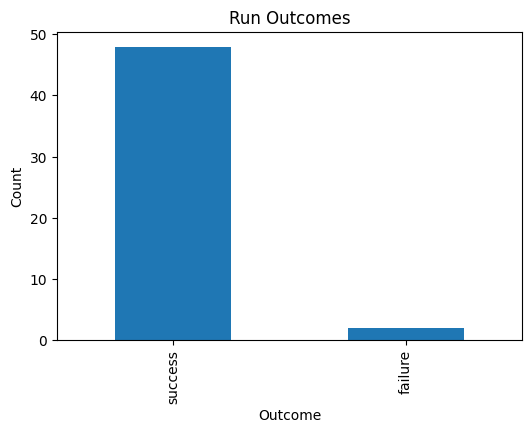

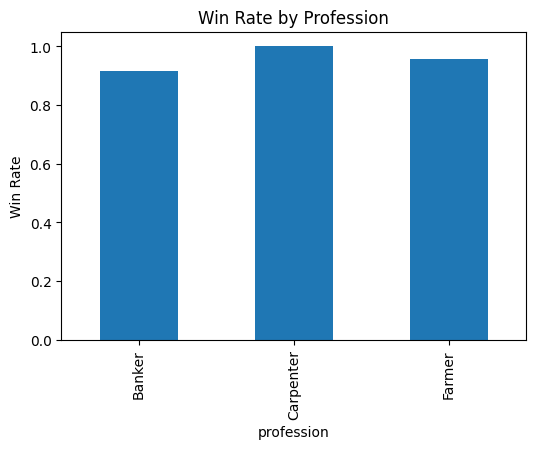

/tmp/ipython-input-3019281186.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_by_month = runs.groupby("start_month")['outcome'].apply(lambda x: (x=="success").mean())


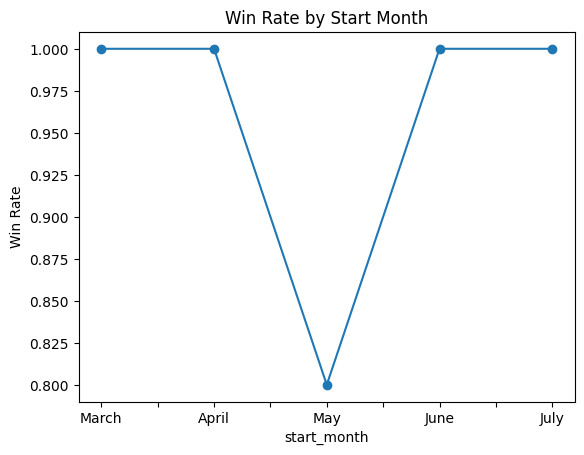

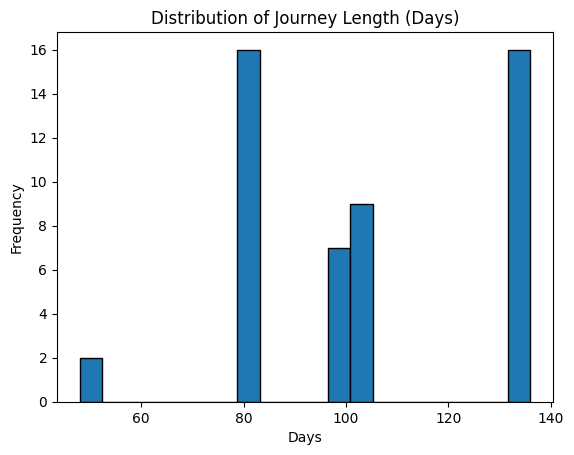

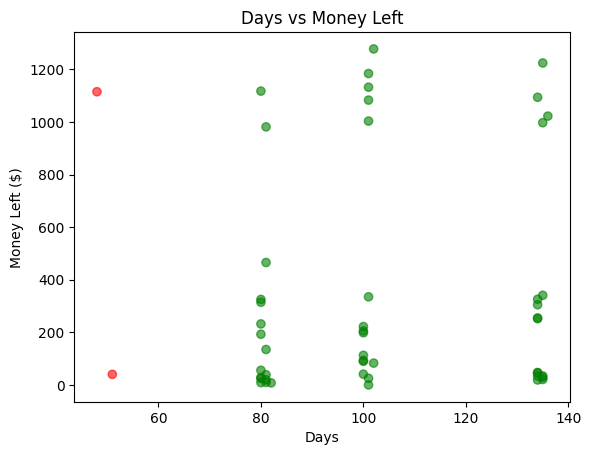

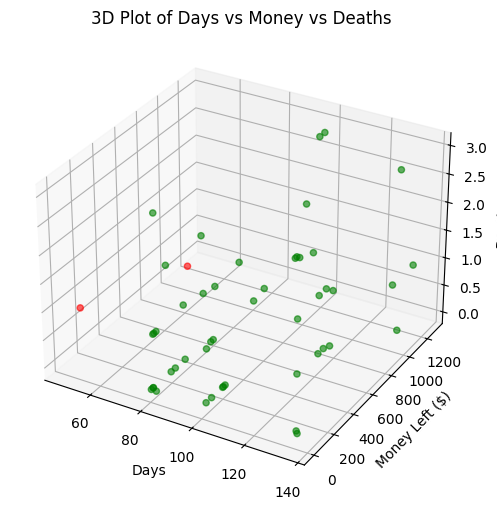

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load run-level data
runs = pd.read_csv("oregon_trail_runs.csv")

# Quick overview
print(runs.head())
print(runs['outcome'].value_counts(normalize=True))

# Outcome distribution
plt.figure(figsize=(6,4))
runs['outcome'].value_counts().plot(kind='bar')
plt.title("Run Outcomes")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.show()

# Win rate by profession
win_rates = runs.groupby("profession")['outcome'].apply(lambda x: (x=="success").mean())
win_rates.plot(kind="bar", figsize=(6,4))
plt.title("Win Rate by Profession")
plt.ylabel("Win Rate")
plt.show()

# Success by start month
month_order = ["March","April","May","June","July"]
runs['start_month'] = pd.Categorical(runs['start_month'], categories=month_order, ordered=True)
win_by_month = runs.groupby("start_month")['outcome'].apply(lambda x: (x=="success").mean())

win_by_month.plot(kind="line", marker="o")
plt.title("Win Rate by Start Month")
plt.ylabel("Win Rate")
plt.show()

# Histogram of journey length
plt.hist(runs['days'], bins=20, edgecolor="black")
plt.title("Distribution of Journey Length (Days)")
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.show()

# Scatter: days vs money left (color by outcome)
colors = np.where(runs['outcome']=="success","green","red")
plt.scatter(runs['days'], runs['money_left'], c=colors, alpha=0.6)
plt.title("Days vs Money Left")
plt.xlabel("Days")
plt.ylabel("Money Left ($)")

color_map = {"success": "green", "failure": "red"}
colors = runs["outcome"].map(color_map)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")

# 3D scatter: Days vs Money Left vs Deaths
ax.scatter(runs["days"], runs["money_left"], runs["deaths"], c=colors, alpha=0.6)

ax.set_xlabel("Days")
ax.set_ylabel("Money Left ($)")
ax.set_zlabel("Deaths")
ax.set_title("3D Plot of Days vs Money vs Deaths")

plt.show()

In [15]:
!sudo apt-get install -y r-base

# Install rpy2
%pip install rpy2

# Load the rpy2 extension
%load_ext rpy2.ipython

# Install R packages
!Rscript -e 'install.packages(c("ggplot2","dplyr","readr"))'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
r-base is already the newest version (4.5.1-1.2204.0).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependency ‘S7’

trying URL 'https://cran.rstudio.com/src/contrib/S7_0.2.0.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/ggplot2_4.0.0.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/dplyr_1.1.4.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/readr_2.1.5.tar.gz'
* installing *source* package ‘S7’ ...
** this is package ‘S7’ version ‘0.2.0’
** package ‘S7’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04.2) 11.4.0’
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-0RQCNp/r-base-4.5.1=. -fstack-protector-strong -Wformat -Wer

Rows: 50 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): profession, pace, ration, start_month, outcome
dbl (17): run_id, days, miles, illnesses, deaths, hunts, rivers, clothing_lo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


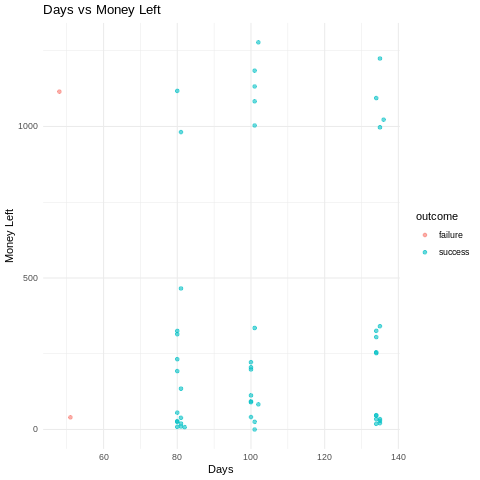

In [29]:
%%R
library(readr)
library(dplyr)
library(ggplot2)

# Load data
runs <- read_csv("oregon_trail_runs.csv")

# Basic overview
table(runs$outcome)

# Outcome distribution
ggplot(runs, aes(x=outcome, fill=outcome)) +
  geom_bar() +
  theme_minimal() +
  labs(title="Run Outcomes", y="Count")

# Win rate by profession
runs %>%
  group_by(profession) %>%
  summarize(win_rate = mean(outcome=="success")) %>%
  ggplot(aes(x=profession, y=win_rate, fill=profession)) +
  geom_col() +
  theme_minimal() +
  labs(title="Win Rate by Profession", y="Win Rate")

# Win rate by start month
month_levels <- c("March","April","May","June","July")
runs$start_month <- factor(runs$start_month, levels=month_levels, ordered=TRUE)

runs %>%
  group_by(start_month) %>%
  summarize(win_rate = mean(outcome=="success")) %>%
  ggplot(aes(x=start_month, y=win_rate, group=1)) +
  geom_line(color="blue") +
  geom_point(size=3, color="darkblue") +
  theme_minimal() +
  labs(title="Win Rate by Start Month", y="Win Rate")

# Histogram of days
ggplot(runs, aes(x=days, fill=outcome)) +
  geom_histogram(binwidth=10, position="dodge") +
  theme_minimal() +
  labs(title="Distribution of Journey Length (Days)", x="Days")

# Scatter: days vs money left
ggplot(runs, aes(x=days, y=money_left, color=outcome)) +
  geom_point(alpha=0.6) +
  theme_minimal() +
  labs(title="Days vs Money Left", x="Days", y="Money Left")